In [ ]:
! pip install networkx
! pip install plotly
! pip install colorlover
! pip install whoosh

     |████████████████████████████████| 471kB 2.7MB/s 


In [ ]:
import pandas as pd
import os
import os.path
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
from collections import Counter
import colorlover as cl
from IPython.display import HTML
from whoosh.analysis import Filter
from nltk.tokenize import RegexpTokenizer
from whoosh.analysis import *
from whoosh import index, writing
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
import nltk
from nltk.stem import *
from bs4 import BeautifulSoup
import html

In [ ]:
!unzip tweets2009-06-0115.csv.zip
TWEETS_DIR = "tweets2009-06-0115.csv.zip"

Archive:  tweets2009-06-0115.csv.zip
  inflating: tweets2009-06-0115.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._tweets2009-06-0115.csv  


In [ ]:
df = pd.read_csv("tweets2009-06-0115.csv", sep='\t')

In [ ]:
df.head()

date        user          tweet
0  2009-06-01 21:43:59  burtonator  No Post Title
1  2009-06-01 21:47:23  burtonator  No Post Title
2  2009-06-02 01:15:44  burtonator  No Post Title
3  2009-06-02 05:17:52  burtonator  No Post Title
4  2009-06-02 23:58:25  burtonator  No Post Title

##I picked "twitpocalypse" as the hashtag I am about to analyze.

In [ ]:
tag = df[df["tweet"].str.lower().str.contains("#twitpocalypse", na=False)].copy()

In [ ]:
pd.set_option('display.max_colwidth',-1)
tag.head(10)

date  ...                                                                                                                             tweet
85526   2009-06-11 19:13:16  ...  Twitter fora do ar? http://migre.me/23Jq #Twitpocalypse                                                                         
89080   2009-06-11 19:18:02  ...  Aha. This offers a bit of #twitpocalypse perspective: http://bit.ly/Kjsxq                                                       
93245   2009-06-11 19:23:53  ...  @thiii18 oskapokspoak vce fikou sabendo desse tal de Twitpocalypse? http://www.twitpocalypse.com/ #twitpocalypse                
96223   2009-06-11 19:29:18  ...  More on the coming #twitpocalypse (Twitter's version of the Y2K bug) at @Mashable - http://mashable.com/2009/06/10/twitpocalypse
97166   2009-06-11 19:31:10  ...  RT @rafalopes: RT @vlribeiro: Contribuindo para o #Twitpocalypse http://www.twitpocalypse.com/                                  
164216  2009-06-11 21:26:39  ...  Minha contribuição para o #Twitpocalypse - http://migre.me/23Wl                                                                 
225550  2009-06-11 22:57:30  ...  RT @pr_socialmedia: The #Twitpocalypse Is Coming! Is Twitterland Doomed?!? http://bit.ly/Qxttm #postrank #socialmedia           
279217  2009-06-12 00:09:26  ...  O Famoso: #twitpocalypse RT @afectado: O twitter vai acabar: http://bit.ly/Wx2aT                                                
374604  2009-06-12 01:49:52  ...  Adoro ficar olhando pra esse reloginho do #Twitpocalypse http://ow.ly/dBtG Em alguns momentos, é emocionante                    
416452  2009-06-12 02:32:27  ...  RT: @rafalopes: RT: @vlribeiro: Contribuindo para o #Twitpocalypse http://www.twitpocalypse.com/                                

[10 rows x 3 columns]

In [ ]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [ ]:
addMentionedColumn(tag)

In [ ]:
tag.head()

date  ...               mentioned
85526  2009-06-11 19:13:16  ...  []                    
89080  2009-06-11 19:18:02  ...  []                    
93245  2009-06-11 19:23:53  ...  [thiii18]             
96223  2009-06-11 19:29:18  ...  [mashable]            
97166  2009-06-11 19:31:10  ...  [rafalopes, vlribeiro]

[5 rows x 4 columns]

### Build Mention Graph

In [ ]:
#match user with users mentioned by them
def mentionGraph(df):
    g = nx.Graph()
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, numberMentions=1)
    
    return g 

# Option 1
# G.add_edge('Alice', 'Bob')
# G['Alice']['Bob']['know'] = 10
# G['Alice']['Bob']['friends'] = 5
# # Option 2
# G.add_edges_from([('Alice', 'Bob', {'know': 10, 'friends': 5})])

##There are 771 nodes and 580 edges in my mention graph.

In [ ]:
Graph = mentionGraph(tag)
print("# nodes:", len(Graph.nodes()))
print("# edges:", len(Graph.edges()))

# nodes: 771
# edges: 580


(array([755.,   9.,   0.,   0.,   2.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([ 1.        ,  4.63636364,  8.27272727, 11.90909091, 15.54545455,
        19.18181818, 22.81818182, 26.45454545, 30.09090909, 33.72727273,
        37.36363636, 41.        ]),
 <a list of 11 Patch objects>)

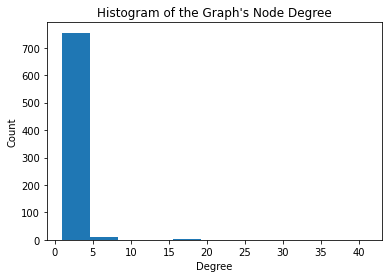

In [ ]:
his = dict(nx.degree(Graph))
plt.title('Histogram of the Graph\'s Node Degree')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.hist(his.values(), bins='auto')

##According the histogram and the value the histogram returns, most of the graph nodes' degree is from 1 to 4.64. There a few that has 4.64 to 8.27 nodes, very few from 8.27 to 41. This tells us most of the users tagged 1 to 4 users in their tweets hashtagged "twitpocalypse".



In [ ]:
edgeDICT = {}
for edge in list(Graph.edges()):
    A = edge[0]
    B = edge[1]
    edgeDICT[edge]=Graph[A][B]['numberMentions']
edgeCounter = Counter(edgeDICT)
print('The top five edges with highest weighs are') #users that mention each other a lot
edgeCounter.most_common(5)

The top five edges with highest weighs are


[(('thesnarkyone', 'justusleeg'), 6),
 (('drahnier', 'jacobcheung'), 4),
 (('diggaclean', 'daschund'), 3),
 (('diggaclean', 'diggaclean'), 3),
 (('admelyssis', '_grid_'), 3)]

In [ ]:
Graph['vinipontes']

AtlasView({'rafalopes': {'numberMentions': 1}, 'vlribeiro': {'numberMentions': 1}})

#Visualize Mention Graph

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
import random
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes()) #node key, tuple value for position
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [ ]:
addRandomPositions(Graph)

In [ ]:
Graph.nodes['scheeren']

{'pos': (-0.6737868924589395, -1.4032794402689306)}

##Visualization of the Mention Graph Indicative of Weights

In [ ]:
HTML(cl.to_html( cl.scales['9'] ))

In [ ]:
# map purd color scale to 300 cells
purd = cl.scales['9']['seq']['Oranges']
purd300 = cl.interp(purd, 300)
HTML(cl.to_html(purd300))

In [ ]:
def plotNetwork(graph): #social queen if big, red if mentions a lot, degree = sum(mentionNumber)
    # closenessCentr = nx.closeness_centrality(Graph) #avg. length of shortest paths from u to all other nodes of the network
    # maxCentr = max(closenessCentr.values()) #max shortest paths
    # minCentr = min(closenessCentr.values()) #min shortest paths 
    maxEdge = 6
    minEdge = 1
    scatters=[]

    for (node1, node2) in graph.edges(): #two nodes in each edge, a line 
        edgeWidth = graph[node1][node2]['numberMentions'] #edge weight
        edgeColor = int(299*(edgeWidth-minEdge)/(maxEdge-minEdge)) #normalize

        x0, y0 = graph.nodes[node1]['pos'] #node1 position
        x1, y1 = graph.nodes[node2]['pos'] #node2 position
    
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth,color=purd300[edgeColor]))
        scatters.append(s)



    for node in graph.nodes(): #a dot
        # nodeCentr = closenessCentr[node] #length of shortest paths for the node
        # nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr)) #normalize
        xPos, yPos = graph.nodes[node]['pos'] #node position
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='none',
                mode='markers', 
                marker=dict(
                    color='#888', 
                    size=nx.degree(graph,node)*2,  #DegreeView({234: 1, 'hello': 1, 'Alice': 3, 'Bob': 2, 'Carlos': 2, 'Dave': 2, 'Eve': 1})      
                    line=dict(width=2))) #a dot with width of 2 
        scatters.append(s)
    
    layout = Layout(showlegend=False, 
                    plot_bgcolor = 'rgba(0,0,0,0.4)')
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [ ]:
configure_plotly_browser_state()
plotNetwork(Graph)

##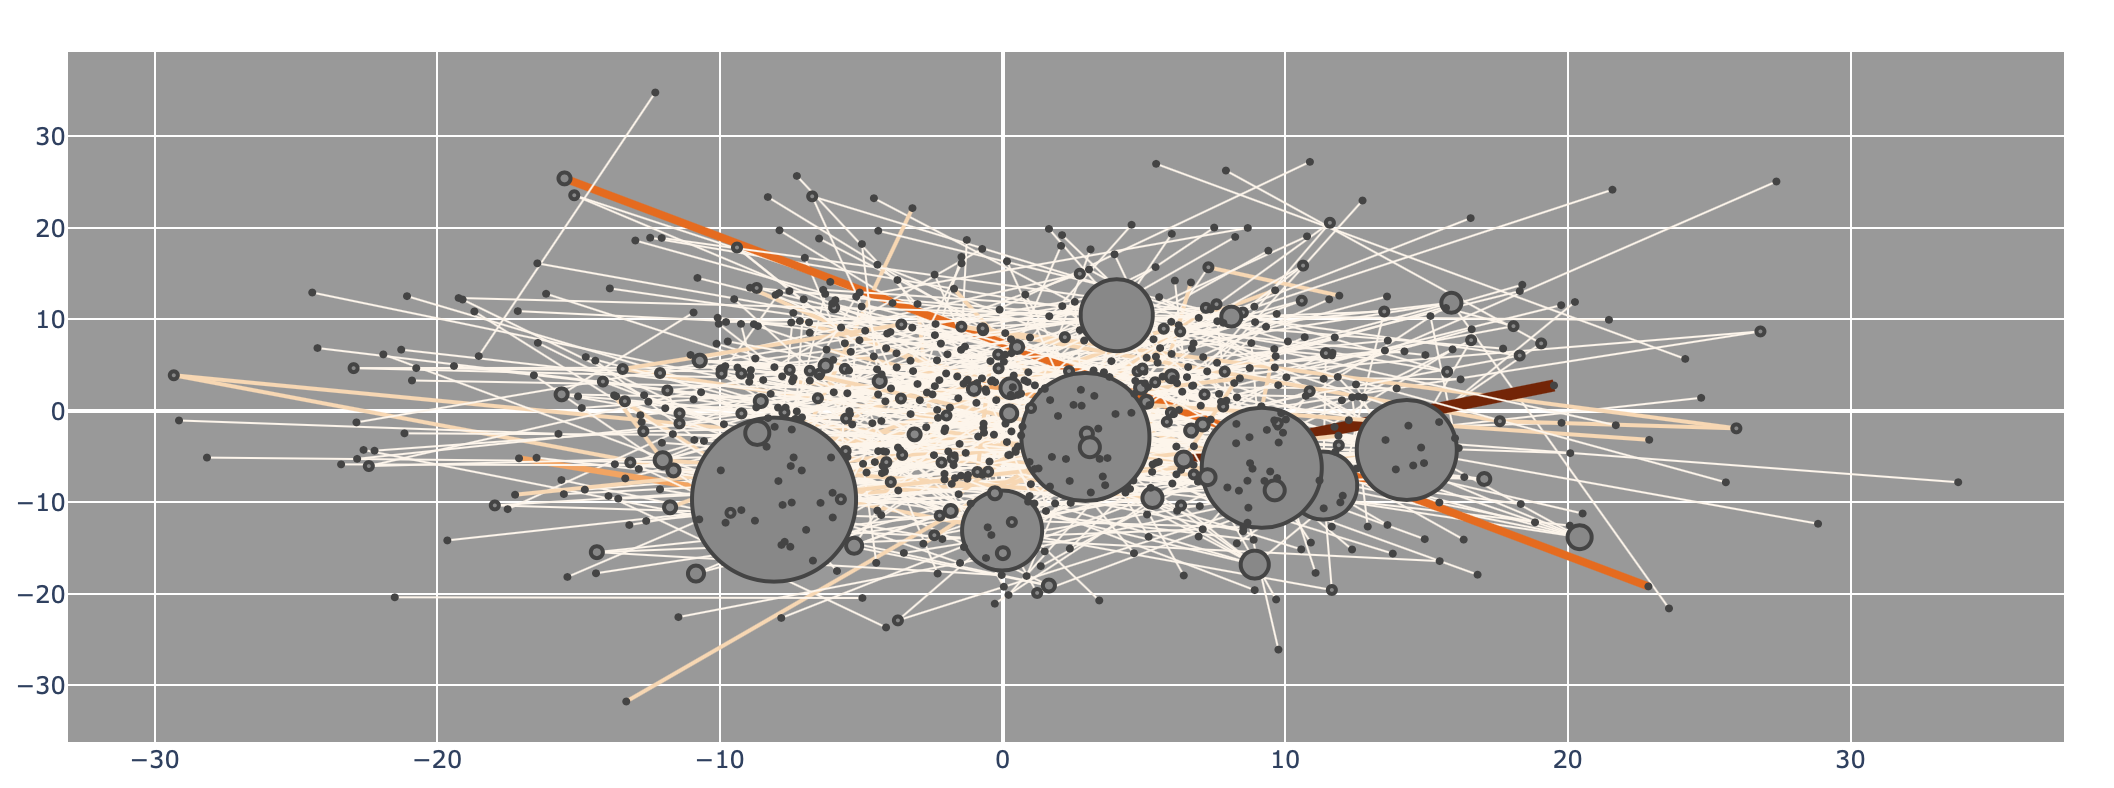

##As is shown in the mention graph above, each node represents a user with the size of it representing how frequent the user is mentioned and the color of eage representing how frequent the two users mention each other. Notice this graph is interactive but cannot be displayed on Github. 

#Content Analysis on "twitpocalypse".

In [ ]:
class CustomFilter(Filter):
    is_morph = True
    def __init__(self, filterFunc, *args, **kwargs):
        self.customFilter = filterFunc
        self.args = args
        self.kwargs = kwargs
    def __eq__(self):
        return (other
                and self.__class__ is other.__class__)
    def __call__(self, tokens):
        for t in tokens:
            if t.mode == 'query': # if called by query parser
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t
            else: # == 'index' if called by indexer
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t

In [ ]:
def remove(txt):
    #remove '\x'
    txt = re.sub(r'\\x(?=\w+)\w+',"",txt )
    # remove html tags
    soup = BeautifulSoup(txt[2:], "html.parser")
    txt = ' '.join(soup.findAll(text=True))
    #Replace the HTML character codes with ASCII equvivalent  
    txt = html.unescape(txt)
    #remove URL
    txt = re.sub(r"http\S+", "", txt) 
    txt = txt.strip()

    return txt


In [ ]:
def tweet_tokenizer(tweet):
    tokenizer = RegexTokenizer() | LowercaseFilter() | StopFilter() #| CustomFilter(LancasterStemmer().stem)
    tweet = remove(tweet)
    tweet = [token.text for token in tokenizer(tweet)]

    return tweet

In [ ]:
allTweets = tag['tweet'].str.cat(sep=' ') #make every thing a str
tweetWords = tweet_tokenizer(allTweets)
wordCounter = Counter(tweetWords)

In [ ]:
wordCounter.most_common(20)

[('twitpocalypse', 1010),
 ('rt', 483),
 ('twitter', 175),
 ('tweetdeck', 101),
 ('twitterrific', 86),
 ('download', 75),
 ('now', 67),
 ('all', 65),
 ('update', 64),
 ('fixes', 64),
 ('what', 62),
 ('my', 60),
 ('please', 53),
 ('iphone', 49),
 ('destroytwitter', 47),
 ('beta', 46),
 ('release', 45),
 ('there', 44),
 ('1.6.4', 44),
 ('restart', 44)]

In [ ]:
set(dict(wordCounter.most_common(3)).keys())

{'rt', 'twitpocalypse', 'twitter'}

###The most common words reflects a Twitter accident that led to the crash of the application. Twitter users tweeted to express their emotions like rage and desparation. They also wished it could be restarted soon.
##Add hover information on the graph and the top three most common words for the user.

In [ ]:
def plotNetwork(graph): #social queen if big, red if mentions a lot, degree = sum(mentionNumber)
    # closenessCentr = nx.closeness_centrality(Graph) #avg. length of shortest paths from u to all other nodes of the network
    # maxCentr = max(closenessCentr.values()) #max shortest paths
    # minCentr = min(closenessCentr.values()) #min shortest paths 
    
    scatters=[]
    maxEdge = 6
    minEdge = 1
    scatters=[]

    for (node1, node2) in graph.edges(): #two nodes in each edge, a line 
        edgeWidth = graph[node1][node2]['numberMentions'] #edge weight
        edgeColor = int(299*(edgeWidth-minEdge)/(maxEdge-minEdge)) #normalize

        x0, y0 = graph.nodes[node1]['pos'] #node1 position
        x1, y1 = graph.nodes[node2]['pos'] #node2 position
    
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                text='Edge Weight='+str(edgeWidth), #not working
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color=purd300[edgeColor]))
        scatters.append(s)



    for node in graph.nodes(): #a dot, degree
        allTweets = tag['tweet'][tag['user']==node].str.cat(sep=' ') #make every thing a str
        tweetWords = tweet_tokenizer(allTweets)
        wordCounter = Counter(tweetWords)
        common = list(dict(wordCounter.most_common(3)).keys())

        # nodeCentr = closenessCentr[node] #length of shortest paths for the node
        # nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr)) #normalize
        xPos, yPos = graph.nodes[node]['pos'] #node position
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text= node + '<br>'+'Most common words:'+', '.join(one for one in common)+'<br>'+'Degree='+str(nx.degree(graph,node)),
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=nx.degree(graph,node)*2,  #DegreeView({234: 1, 'hello': 1, 'Alice': 3, 'Bob': 2, 'Carlos': 2, 'Dave': 2, 'Eve': 1})      
                    line=dict(width=2))) #a dot with width of 2 
        scatters.append(s)
    
    layout = Layout(showlegend=False,
                    plot_bgcolor = 'rgba(0,0,0,0.4)')
  
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [ ]:
configure_plotly_browser_state()
plotNetwork(Graph)

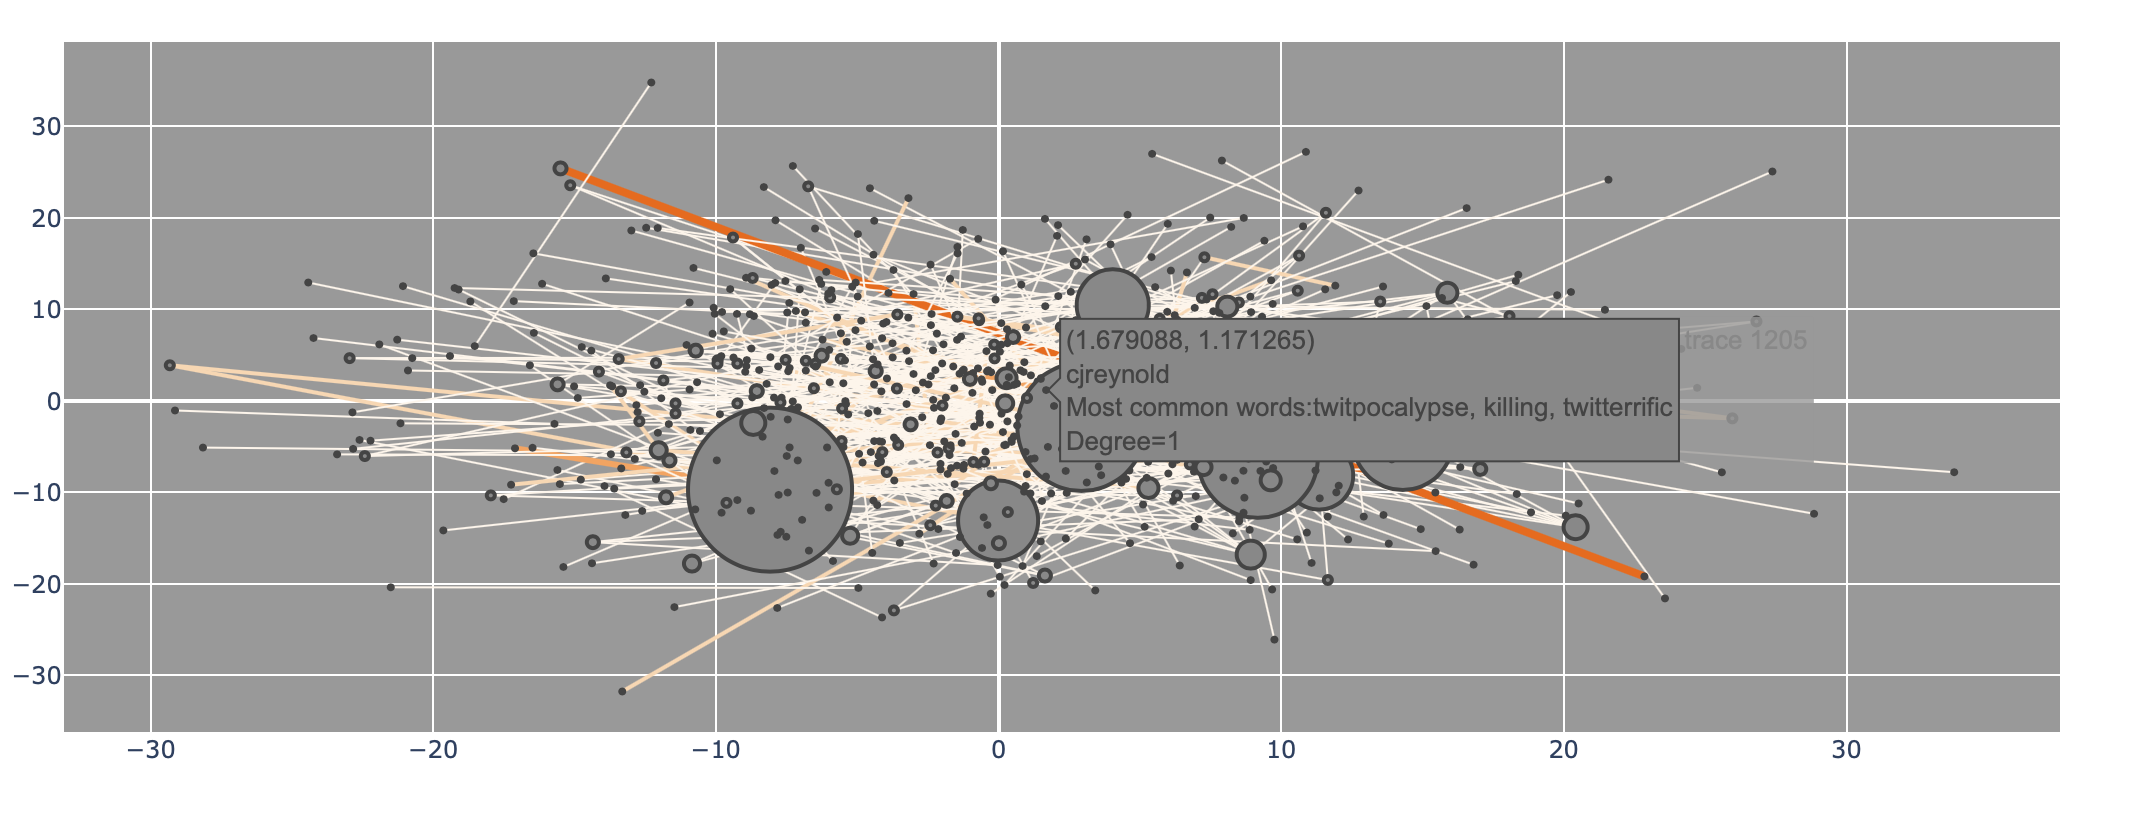

## This step to add hover information on the graph to show user name and most common words used by the user. I also added degree to show the interaction between users and the size of the node. Notice this graph is interactive but cannot be displayed on Github. 


#Centrality
##(a) Difference between degree centrality and page rank.

In [ ]:
degreeCentrality = nx.degree_centrality(Graph)
degreeCentr = sorted(degreeCentrality.items(), key=lambda x:x[1] ,reverse=True)
print("The top five degree centrality of the mention graph is \n %s" % degreeCentr[0:5])

The top five degree centrality of the mention graph is 
 [('diggaclean', 0.053246753246753244), ('destroytoday', 0.04155844155844156), ('tweetdeck', 0.03896103896103896), ('twitterrific', 0.032467532467532464), ('techcrunch', 0.025974025974025976)]


In [ ]:
pagerank = nx.pagerank(Graph)
pagerk = sorted(pagerank.items(), key=lambda x:x[1] ,reverse=True)
print("The top five degree centrality of the mention graph is \n %s" % pagerk[0:5])
pagerk_=[item[0]for item in pagerk]

The top five degree centrality of the mention graph is 
 [('diggaclean', 0.023664249322972748), ('destroytoday', 0.019563059899441217), ('tweetdeck', 0.017626742836975295), ('twitterrific', 0.014514778963898077), ('hourlytechdeals', 0.0112982462738175)]


In [ ]:
pagerk_.index('hourlytechdeals')

4

##（b) Centrality Visualization
#### degree_centrality

In [ ]:
def plotNetworkDegree(graph): #social queen if big red, edge :red if mentions a lot, degree = sum(mentionNumber)
  
    maxCentr = max(degreeCentrality.values()) #max shortest paths
    minCentr = min(degreeCentrality.values()) #min shortest paths 
    
    scatters=[]
    
    #mentionnumber 
    maxEdge = 6
    minEdge = 1
    scatters=[]

    for (node1, node2) in graph.edges(): #two nodes in each edge, a line 
        edgeWidth = graph[node1][node2]['numberMentions'] #edge weight
        edgeColor = int(299*(edgeWidth-minEdge)/(maxEdge-minEdge)) #normalize

        x0, y0 = graph.nodes[node1]['pos'] #node1 position
        x1, y1 = graph.nodes[node2]['pos'] #node2 position
    
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                text='Edge Weight='+str(edgeWidth), #not working
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color=purd300[edgeColor]))
        scatters.append(s)



    for node in graph.nodes(): #a dot, degree
        allTweets = tag['tweet'][tag['user']==node].str.cat(sep=' ') #make every thing a str
        tweetWords = tweet_tokenizer(allTweets)
        wordCounter = Counter(tweetWords)
        common = list(dict(wordCounter.most_common(3)).keys())

        nodeCentr = degreeCentrality[node] #length of shortest paths for the node
        degreeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr)) #normalize
        xPos, yPos = graph.nodes[node]['pos'] #node position
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text= node + '<br>'+'Most common words:'+', '.join(one for one in common)+'<br>'+'Degree='+str(nx.degree(graph,node)),
                mode='markers', 
                marker=dict(
                    color=purd300[degreeColor], 
                    size=degreeCentrality[node]*2000,  #DegreeView({234: 1, 'hello': 1, 'Alice': 3, 'Bob': 2, 'Carlos': 2, 'Dave': 2, 'Eve': 1})      
                    line=dict(width=2))) #a dot with width of 2 
        scatters.append(s)
    
    layout = Layout(showlegend=False,
                    plot_bgcolor = 'rgba(0,0,0,0.4)')
    
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [ ]:
configure_plotly_browser_state()
plotNetworkDegree(Graph)

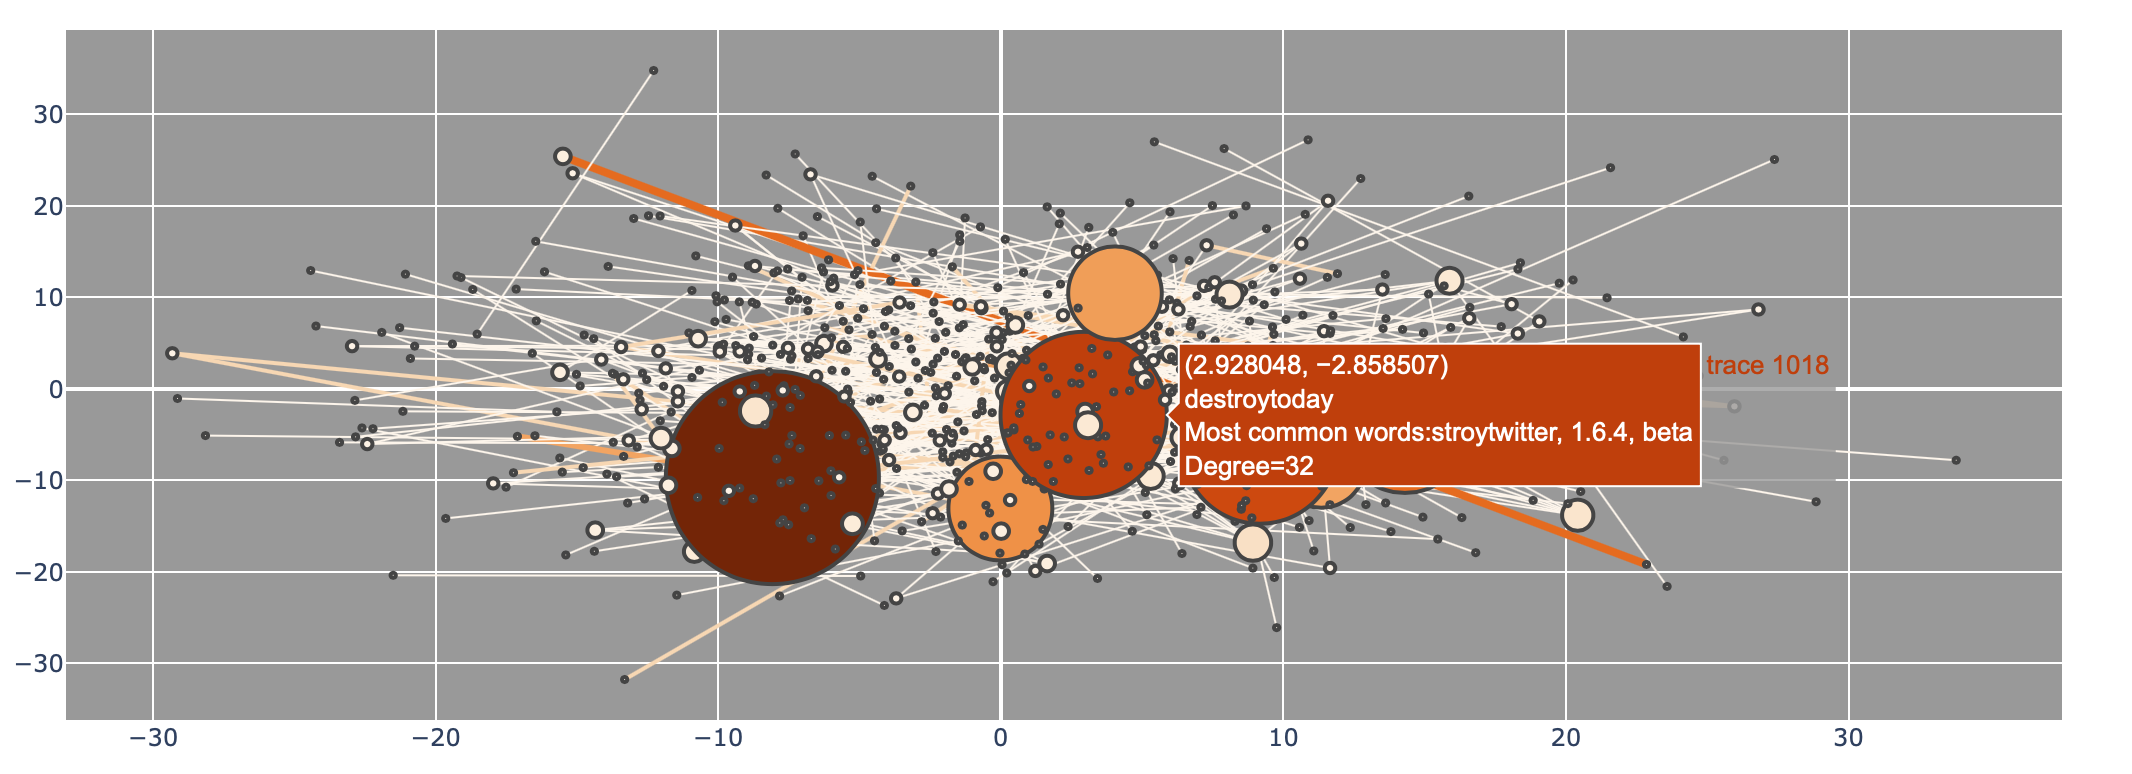

##For this step, I color coded each node with the size and color representing the number of mentions.

####page_rank

In [ ]:
def plotNetworkPage(graph): #big, red if credible, degree = sum(mentionNumber)
  
    maxCentr = max(pagerank.values()) #max shortest paths
    minCentr = min(pagerank.values()) #min shortest paths 
    
    scatters=[]
    
    #mentionnumber 
    maxEdge = 6
    minEdge = 1
    scatters=[]

    for (node1, node2) in graph.edges(): #two nodes in each edge, a line 
        edgeWidth = graph[node1][node2]['numberMentions'] #edge weight
        edgeColor = int(299*(edgeWidth-minEdge)/(maxEdge-minEdge)) #normalize

        x0, y0 = graph.nodes[node1]['pos'] #node1 position
        x1, y1 = graph.nodes[node2]['pos'] #node2 position
    
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                text='Edge Weight='+str(edgeWidth), #not working
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color=purd300[edgeColor]))
        scatters.append(s)



    for node in graph.nodes(): #a dot, degree
        allTweets = tag['tweet'][tag['user']==node].str.cat(sep=' ') #make every thing a str
        tweetWords = tweet_tokenizer(allTweets)
        wordCounter = Counter(tweetWords)
        common = list(dict(wordCounter.most_common(3)).keys())

        nodeCentr = pagerank[node] #length of shortest paths for the node
        degreeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr)) #normalize
        xPos, yPos = graph.nodes[node]['pos'] #node position
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text= node + '<br>'+'Most common words:'+', '.join(one for one in common)+'<br>'+'Pagerank='+str(pagerk_.index(node)),
                mode='markers', 
                marker=dict(
                    color=purd300[degreeColor], 
                    size=pagerank[node]*4000, #DegreeView({234: 1, 'hello': 1, 'Alice': 3, 'Bob': 2, 'Carlos': 2, 'Dave': 2, 'Eve': 1})      
                    line=dict(width=2))) #a dot with width of 2 
        scatters.append(s)
    
    layout = Layout(showlegend=False,
                    plot_bgcolor = 'rgba(0,0,0,0.1)')
                
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [ ]:
def applyLayout(graph, layoutFunc):
    posDict = layoutFunc(graph) 
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [ ]:
# GraphRandom = Graph.copy()
# applyLayout(GraphRandom, nx.random_layout)
configure_plotly_browser_state()
plotNetworkPage(Graph)

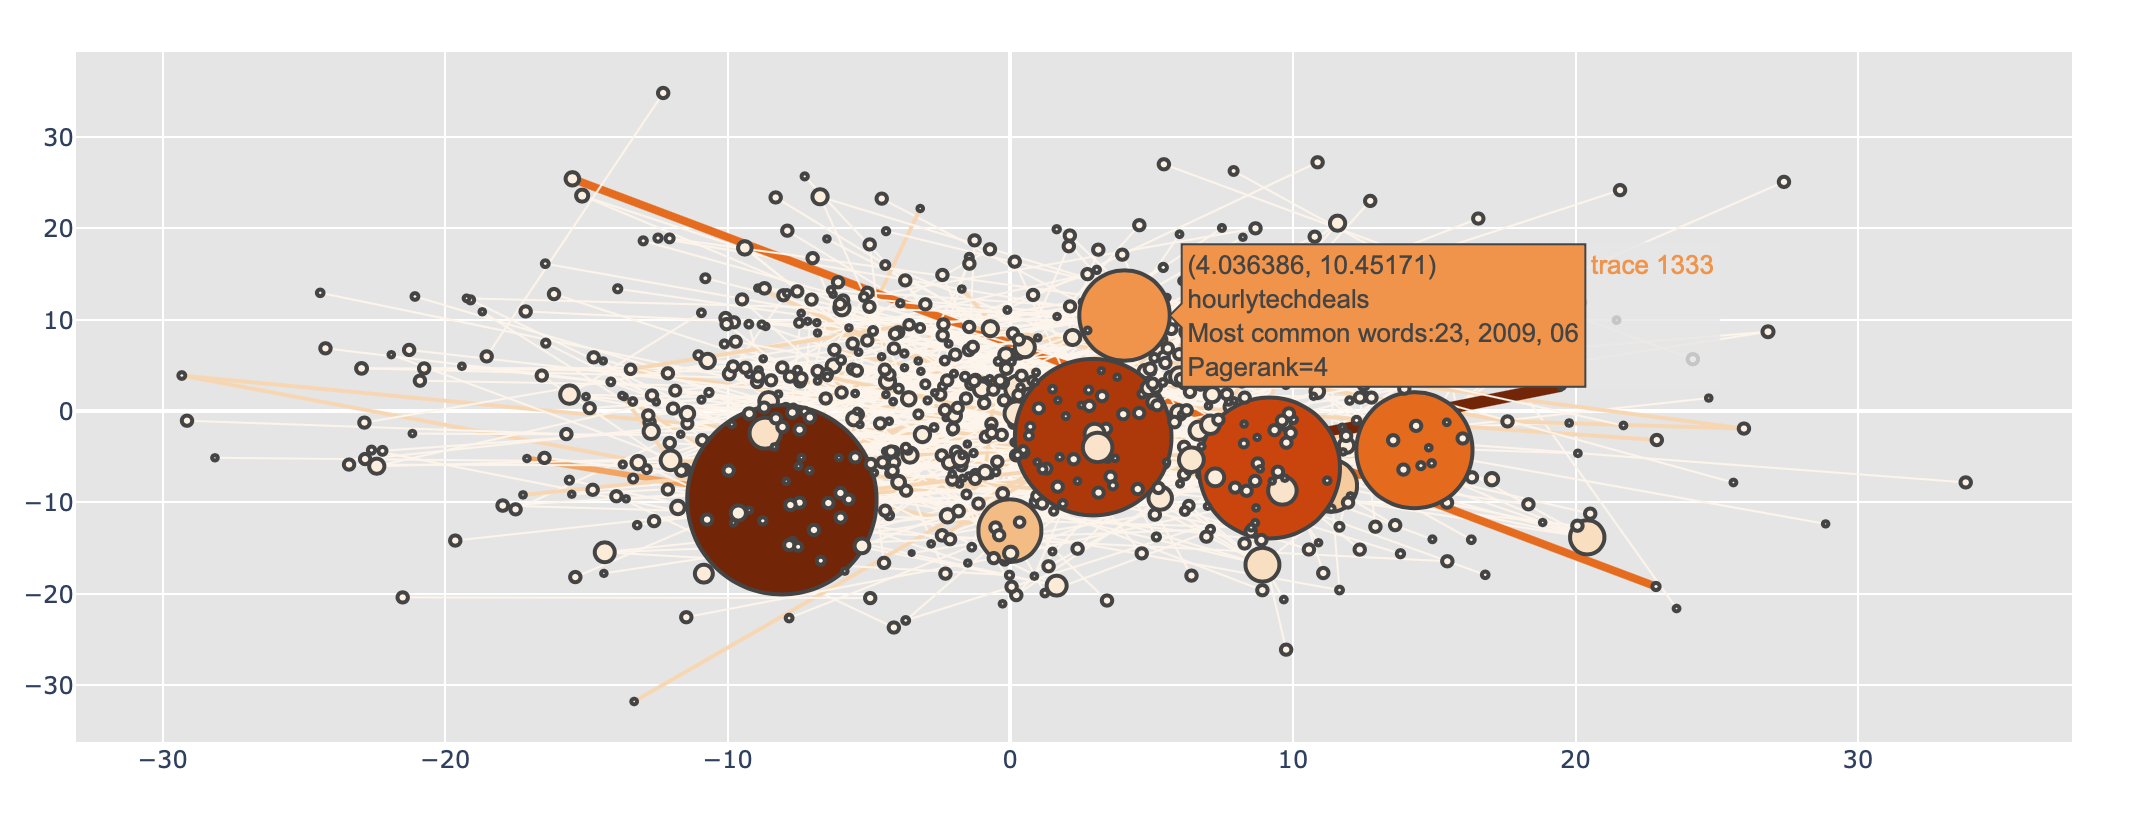

## For this step, I used page rank instead of degree centrality to relect the impact of each user with the color and size of each node representing the rank. 

#(c)
###1. Reasons for observed differences

*   The size and color of the mention graph is based on the 
node's degree centrality or page rank value. Because the value of degree centrality is generally greater than page rank, the size of the node of degree centrality is bigger than that of page rank. 

*   The rank of the top nodes is similar with few noticeable differences. The fifth and sixth biggest node of degree centrality is significantly smaller with less intense color than page rank.
*   The difference of the graph lies in the difference of the two algorithms. Degree centrality only counts the the number of nodes each node connects to and normalizes it; whereas pagerank calculates the credit of each node. The credit is higher when node 1 is pointed to the most by other credible nodes who points to few other nodes but node 1.  

###2. Why is page rank more meaningful than degree centrality?

**Page Rank** produces a more meaninful interpretation because it takes into account the credibility of each node rather than merely the count of other nodes it connects to. If a node is pointed to a lot by other nodes of poor quality, it would rank high for degree centrality but not page rank.

#Connectivity Patterns
##(a)Clique Analysis
A clique in an undirected graph is a subset
of the nodes, such that every two dierent nodes are adjacent (directly connected with an edge)
#### Number of maximal cliques

In [ ]:
nx.graph_number_of_cliques(Graph) #Number of maximal cliques in your graph.

552

####Size of the largest clique in the graph

In [ ]:
nx.graph_clique_number(Graph)  #size of the largest clique in the graph

4

####Number of maximal cliques for each node

In [ ]:
nx.number_of_cliques(Graph) #Number of maximal cliques for each node 

{'': 3,
 '12c4': 1,
 '12ian34': 1,
 '1god': 1,
 '9swords': 1,
 '_arf_': 1,
 '_chapman': 1,
 '_grid_': 1,
 '_lennart': 1,
 'aaronpk': 1,
 'achura': 1,
 'acomicbookgirl': 1,
 'acowen': 1,
 'ada': 1,
 'adam_griffiths': 1,
 'adamjschmidt': 2,
 'adammshankman': 1,
 'adamwc': 1,
 'adhero': 2,
 'adman47': 1,
 'admelyssis': 1,
 'adognamedpants': 1,
 'adrian_scott': 1,
 'afectado': 1,
 'agarzaq': 1,
 'agasalim': 1,
 'agentbooth': 1,
 'ahzing': 2,
 'aithyne': 1,
 'ajhab': 2,
 'alaidenc': 1,
 'alanbarkwill': 1,
 'albsharah': 1,
 'ali_bubblegate': 1,
 'aliasgrace': 1,
 'alisha16988': 2,
 'alohaaircargo': 1,
 'alqaeda': 1,
 'amandapalmer': 1,
 'ammidon': 1,
 'amybp': 1,
 'andersonz1': 1,
 'andinarvaez': 1,
 'andrewgirdwood': 1,
 'andybumatai': 5,
 'andykaufman': 2,
 'anewmode': 2,
 'angel1ruiz': 1,
 'angelcastaneda': 1,
 'anked': 1,
 'ankhwatcher': 1,
 'annarelle': 1,
 'annus_mirabilis': 1,
 'anrahman': 1,
 'anthonywright': 1,
 'anti_hype': 1,
 'aplusk': 1,
 'ardub57': 1,
 'arevers': 1,
 'arielaros

####Size of the largest maximal clique containing each given node

In [ ]:
nx.node_clique_number(Graph) #Size of the largest maximal clique containing each given node. 

{'': 2,
 '12c4': 2,
 '12ian34': 2,
 '1god': 2,
 '9swords': 3,
 '_arf_': 3,
 '_chapman': 2,
 '_grid_': 2,
 '_lennart': 2,
 'aaronpk': 2,
 'achura': 2,
 'acomicbookgirl': 2,
 'acowen': 2,
 'ada': 2,
 'adam_griffiths': 2,
 'adamjschmidt': 2,
 'adammshankman': 2,
 'adamwc': 2,
 'adhero': 2,
 'adman47': 2,
 'admelyssis': 2,
 'adognamedpants': 2,
 'adrian_scott': 2,
 'afectado': 2,
 'agarzaq': 2,
 'agasalim': 2,
 'agentbooth': 2,
 'ahzing': 3,
 'aithyne': 2,
 'ajhab': 2,
 'alaidenc': 2,
 'alanbarkwill': 2,
 'albsharah': 2,
 'ali_bubblegate': 2,
 'aliasgrace': 2,
 'alisha16988': 2,
 'alohaaircargo': 2,
 'alqaeda': 2,
 'amandapalmer': 2,
 'ammidon': 2,
 'amybp': 2,
 'andersonz1': 2,
 'andinarvaez': 2,
 'andrewgirdwood': 2,
 'andybumatai': 2,
 'andykaufman': 2,
 'anewmode': 2,
 'angel1ruiz': 2,
 'angelcastaneda': 2,
 'anked': 2,
 'ankhwatcher': 2,
 'annarelle': 2,
 'annus_mirabilis': 2,
 'anrahman': 2,
 'anthonywright': 2,
 'anti_hype': 2,
 'aplusk': 2,
 'ardub57': 2,
 'arevers': 2,
 'arielaros

##（b) Insights draw from the connectivity patterns analysis
*  The largest clique is revolved around 'deabush', 'digeratii, 'skanwar', and 'newfiejobber'.
*   
There are 522 cliques, which indicates the graph is sparsely connected. People stays in small social groups (mostly 2-3 people) even for the largest group they are in. 764 out of 771 accounts have less than 10 groups.
*   The largest social group is 4 given the largest clieque 4. 
* There are social people who are in a large number of groups that consist of a few people, for example, 'diggaclean' has 38 groups with 3 people in his largets group. They are key links in the graph. They talk to a lot of people who just talk to a few people and do not interact outside their bubble.


In [ ]:
size = nx.node_clique_number(Graph)
sizeList = sorted(size.items(),key=lambda x:x[1], reverse=True)
sizeList[:4]

[('deabush', 4), ('digeratii', 4), ('skanwar', 4), ('newfiejobber', 4)]

In [ ]:
number = nx.number_of_cliques(Graph)
numberList = sorted(number.items(),key=lambda x:x[1], reverse=True)
numberList[:10]

[('diggaclean', 38),
 ('destroytoday', 32),
 ('tweetdeck', 29),
 ('twitterrific', 25),
 ('techcrunch', 20),
 ('hourlytechdeals', 18),
 ('jason_pollock', 17),
 ('kimsherrell', 7),
 ('mashable', 6),
 ('nk', 6)]

In [ ]:
size['diggaclean']

3

(array([  0.,   3., 743.,  21.,   4.,   0.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

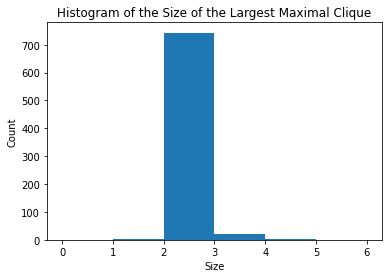

In [ ]:
his = dict(size)
bins_list=[0,1,2,3,4,5,6]
plt.title('Histogram of the Size of the Largest Maximal Clique')
plt.ylabel("Count")
plt.xlabel("Size")
plt.hist(his.values(), bins=bins_list)

(array([  0., 764.,   2.,   3.,   2.,   0.]),
 array([-10,   0,  10,  20,  30,  40,  50]),
 <a list of 6 Patch objects>)

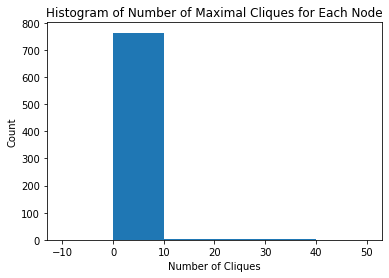

In [ ]:
his = dict(number)
bins_list=[-10,0,10,20, 30,40,50]
plt.title('Histogram of Number of Maximal Cliques for Each Node')
plt.ylabel("Count")
plt.xlabel("Number of Cliques")
plt.hist(his.values(), bins=bins_list)